In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import parse_runs
import plotting_tools

In [2]:
df, segments = parse_runs.load_and_process_json('data/dynamic_log_icra2024_3trees_deletion_smalltrees.json')
segs_df = parse_runs.merge_segments(segments)

df['false_given_wasted'] = segs_df[segs_df['end_event'] == 'FOUND_FAKE_GOAL (planned)'].groupby('run_index')['path_length'].sum()
df['wasted_per_total'] = df['false_given_wasted'] / df['total_path_length']
df['visited_any'] = df['n_visited'] > 0

In [3]:
in_false_variation = df[df.groupby(['n_given','tree_model'])['n_false'].transform('nunique') > 1]
stats = in_false_variation.groupby(['visibility_model','planner','n_discoverable','n_false','n_given','tree_model'])[['length_per_visited','false_given_wasted']].mean().reset_index()

In [4]:
tree_models = df['tree_model'].unique()
planners = df['planner'].unique()
n_cols = df[df['n_false'] > 0].groupby(['tree_model'])['n_given'].nunique().max() + 1

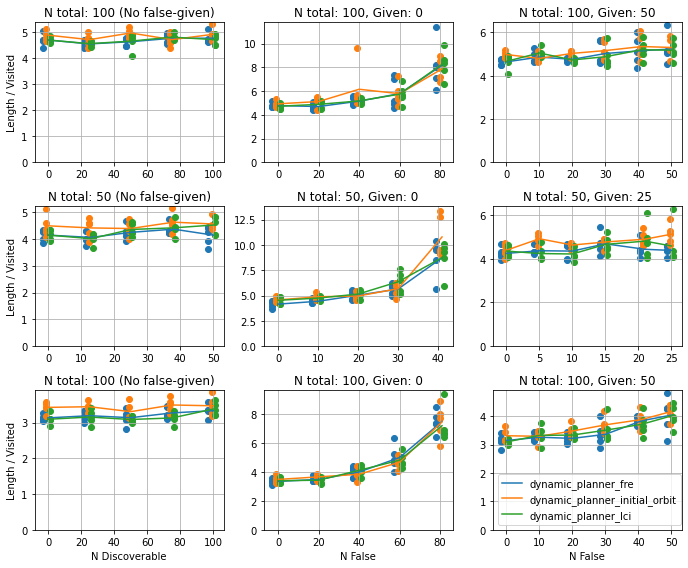

In [11]:
  
def plot_metric(metric):
    """
    Plot a specified metric against the relevant variables.

    Parameters:
    metric (str): The metric to be plotted.

    Returns:
    None
    """
    # Create a figure with subplots based on the number of tree models and columns specified
    fix, ax_rows = plt.subplots(len(tree_models), n_cols, figsize=(10,8))

    # Iterate over each group of tree models and corresponding axes
    for (tree_model, tree_df), ax_row in zip(df.groupby('tree_model'), ax_rows):
        
        # Filter the DataFrame to include only rows with no false discoveries and sort by discoverable counts
        no_false = tree_df[tree_df['n_false'] == 0].sort_values('n_discoverable')
        
        # Select the first axis in the current row for plotting discoverable vs. the specified metric
        ax_disc = ax_row[0]
        plotting_tools.plot_grouped_with_offsets(ax_disc, no_false, 'planner', 'n_discoverable', metric)
        ax_disc.set_ylim(bottom=0)
        ax_disc.grid()
        
        n_total = tree_df['n_total'].max()
        ax_disc.set_title('N total: {} (No false-given)'.format(n_total))
            
        # Select the rest of the axes in the current row for plotting false vs. the specified metric
        ax_false = ax_row[1:]
        
        # Filter the tree DataFrame to include only rows with multiple unique n_false values
        false_df = tree_df[tree_df.groupby(['n_given'])['n_false'].transform('nunique') > 1]
        
        # Iterate over each group of n_given values and their corresponding data within the false_df DataFrame
        for ax, (n_given, given_df) in zip(ax_false, false_df.groupby('n_given')):
            ax.set_title('N total: {}, Given: {}'.format(n_total, n_given))
            plotting_tools.plot_grouped_with_offsets(ax, given_df, 'planner', 'n_false', metric)
            ax.set_ylim(bottom=0)
            ax.grid()
            
    ax_rows[-1,0].set_xlabel('N Discoverable')
    
    for ax in ax_rows[-1,1:]:
        ax.set_xlabel('N False')
        
    for ax in ax_rows[:,0]:
        ax.set_ylabel({
            'length_per_visited': 'Length / Visited',
            'n_visited': 'n_visited'
        }[metric])
    
    # ax_disc.set_ylabel('Path length / Visited')
            
    ax_rows[-1,-1].legend()
    
    plt.tight_layout()

# Call the function with the desired metric
plot_metric('length_per_visited')
plt.savefig('plots_dynamic_goalset.pdf')

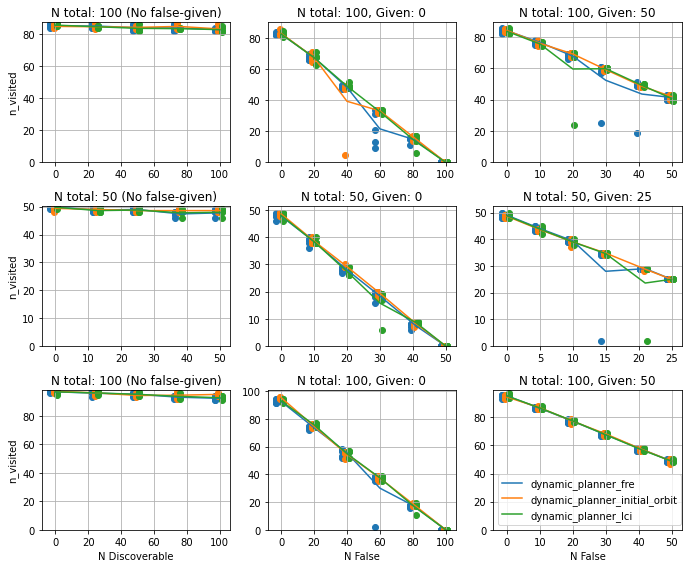

In [12]:
plot_metric('n_visited')
plt.savefig('plots_dynamic_goalset_nvisited.pdf')

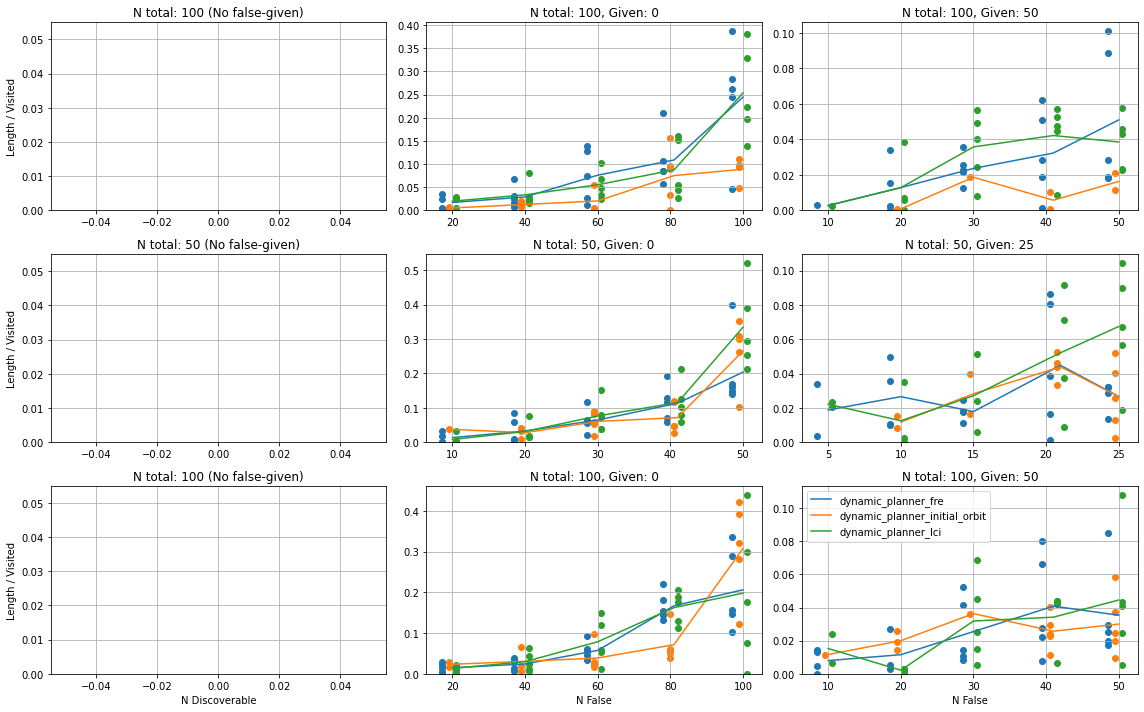

In [8]:
plot_metric('wasted_per_total')